In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgbm

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import joblib

import re 

import datetime 

plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def get_intermediate(df):
    global _df
    _df = df
    return df

In [3]:
!ls ../../datasets/

elo_rating.csv		     fifa_ranking_before_wc_preprocessed.csv
elo_rating_preprocessed.csv  fifa_world_cup_2022
fifa_ranking_before_wc.csv   international_football_results


## Modelagem

Considerações:
- Usamos dados de 2018 em diante para validação
- Apesar da pandemia, houve jogos, inclusive de qualificação da FIFA.
- Só podemos usar features que conseguimos estimar com boa confiança para as partidas da Copa de 2022. Isso vai guiar algumas decisões de ficar ou não com certas features. Para as métricas de times como defesa, ataque e goleiro, vamos manter o último dado disponível
- removemos torneios com menos de 10 partidas

## Usando `fifa_world_cup_2022`

In [4]:
def get_2022_players():
    df = pd.read_csv("../../datasets/international_football_results/results_preprocessed.csv")
    players = (
        df[
            (df.tournament == 'FIFA World Cup')
            & (df.year == 2022)
        ]
        [['home_team', 'away_team']]
        .to_numpy()
        .flatten()
    )
    return np.unique(players)

players2022 = get_2022_players()
print("# Players: ", len(players2022))
players2022

# Players:  32


array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

In [6]:
def merge_names(df):
    mapper = {
        'IR Iran': 'Iran',
        'USA': 'United States',
        'Korea Republic': 'South Korea'
    }
    for col in ['home_team', 'away_team']:
        df[col] = df[col].apply(lambda x: mapper.get(x, x))
    return df
    

df_fifa_world_cup_2022 = (
    pd.read_csv('../../datasets/fifa_world_cup_2022/fifa_world_cup_2022.csv')
    .pipe(merge_names)
    .pipe(get_intermediate)
    [(_df.home_team.isin(players2022)) | (_df.away_team.isin(players2022))]
)


df_fifa_world_cup_2022.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1993-08-11,Sweden,Switzerland,Europe,Europe,4,3,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
all_players = set(df_fifa_world_cup_2022.home_team.to_list() + df_fifa_world_cup_2022.away_team.to_list())

assert set(players2022).issubset(all_players), [t for t in players2022 if t not in all_players]

In [8]:
df_fifa_world_cup_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9321 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           9321 non-null   object 
 1   home_team                      9321 non-null   object 
 2   away_team                      9321 non-null   object 
 3   home_team_continent            9321 non-null   object 
 4   away_team_continent            9321 non-null   object 
 5   home_team_fifa_rank            9321 non-null   int64  
 6   away_team_fifa_rank            9321 non-null   int64  
 7   home_team_total_fifa_points    9321 non-null   int64  
 8   away_team_total_fifa_points    9321 non-null   int64  
 9   home_team_score                9321 non-null   int64  
 10  away_team_score                9321 non-null   int64  
 11  tournament                     9321 non-null   object 
 12  city                           9321 non-null   

## Preprocess

In [9]:
elegible_tournaments = (
    df_fifa_world_cup_2022
    .groupby('tournament')
    .count()['home_team']
    .sort_values()
    .reset_index()
    .rename(columns={'home_team': 'matches'})
    .query('matches >= 10')
)

elegible_tournaments

,tournament,matches
15,African Nations Championship qualification,10
16,King Hassan II Tournament,11
17,Dynasty Cup,11
18,Korea Cup,14
19,United Arab Emirates Friendship Tournament,14
20,Lunar New Year Cup,16
21,Amílcar Cabral Cup,17
22,Oceania Nations Cup,18
23,Kirin Challenge Cup,20
24,King's Cup,21


In [13]:
features_cols = [
    'home_team',
    'away_team',
    'home_team_fifa_rank',
    'away_team_fifa_rank',
    'home_team_total_fifa_points',
    'away_team_total_fifa_points',
#     'home_team_score',
#     'away_team_score',
    'tournament',
    'neutral_location',
    'home_team_goalkeeper_score',
    'away_team_goalkeeper_score',
    'home_team_mean_defense_score',
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score',
    'away_team_mean_midfield_score'
]

target_col = ['home_team_result']
# labels_names = ['Lose', 'Draw', 'Win']

def make_label(x):
    if x == 'Win':
        return 1
    elif x == 'Lose':
        return -1 
    elif x == 'Draw': 
        return 0
    
def add_features(df):
    df['home2away_fifa_point_diff'] = df.home_team_total_fifa_points - df.away_team_total_fifa_points
    df['home2away_fifa_point_pdiff'] = df.home_team_total_fifa_points/df.away_team_total_fifa_points - 1
    
    return df
    

def preprocess_fifa_world_cup_2022(
    df, 
    elegible_tournaments=elegible_tournaments,
):
    df = df.copy()
    df = df[df.tournament.isin(elegible_tournaments.tournament)]
    df = (
        df
        .assign(date = pd.to_datetime(df.date))
        .pipe(get_intermediate)
        .assign(year = _df.date.dt.year)
        .assign(neutral_location = _df.neutral_location.astype('bool'))
        .set_index('date')
        .pipe(add_features)
        
    )
    df['home_team_result'] = df['home_team_result'].apply(lambda x: make_label(x))
        
    
    return df

In [14]:
X = preprocess_fifa_world_cup_2022(df_fifa_world_cup_2022)

X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9257 entries, 1993-08-08 to 2022-06-14
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team                      9257 non-null   object 
 1   away_team                      9257 non-null   object 
 2   home_team_continent            9257 non-null   object 
 3   away_team_continent            9257 non-null   object 
 4   home_team_fifa_rank            9257 non-null   int64  
 5   away_team_fifa_rank            9257 non-null   int64  
 6   home_team_total_fifa_points    9257 non-null   int64  
 7   away_team_total_fifa_points    9257 non-null   int64  
 8   home_team_score                9257 non-null   int64  
 9   away_team_score                9257 non-null   int64  
 10  tournament                     9257 non-null   object 
 11  city                           9257 non-null   object 
 12  country                       

## Brief EDA

<AxesSubplot: >

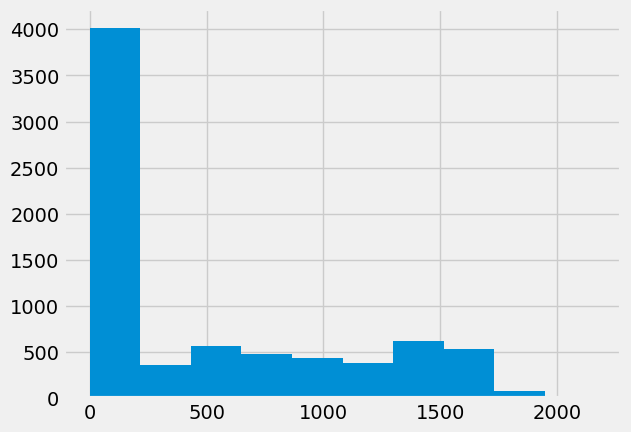

In [42]:
X['2000':].home_team_total_fifa_points.hist()

In [45]:
X[X.home2away_fifa_point_pdiff.isnull()][:'2011'][['home_team','away_team','home_team_total_fifa_points', 'away_team_total_fifa_points']]

,home_team,away_team,home_team_total_fifa_points,away_team_total_fifa_points
date,,,,
1993-08-08,Bolivia,Uruguay,0,0
1993-08-08,Brazil,Mexico,0,0
1993-08-08,Ecuador,Venezuela,0,0
1993-08-08,Paraguay,Argentina,0,0
1993-08-11,Sweden,Switzerland,0,0
...,...,...,...,...
2011-08-10,Tunisia,Mali,0,0
2011-08-10,United States,Mexico,0,0
2011-08-10,Wales,Australia,0,0


In [47]:
(
    X
    .assign(is_zero_home = X.home_team_total_fifa_points == 0)
    .assign(is_zero_away = X.away_team_total_fifa_points == 0)
    [X.home2away_fifa_point_pdiff.isnull()].groupby(['year', 'is_zero_home', 'is_zero_away'])
    ['home_team']
    .count()
)

year  is_zero_home  is_zero_away
1993  True          True            113
1994  True          True            255
1995  True          True            243
1996  True          True            315
1997  True          True            343
1998  True          True            277
1999  True          True            245
2000  True          True            363
2001  True          True            355
2002  True          True            298
2003  True          True            297
2004  True          True            381
2005  True          True            327
2006  True          True            326
2007  True          True            338
2008  True          True            371
2009  True          True            359
2010  True          True            320
2011  True          True            195
Name: home_team, dtype: int64

<AxesSubplot: >

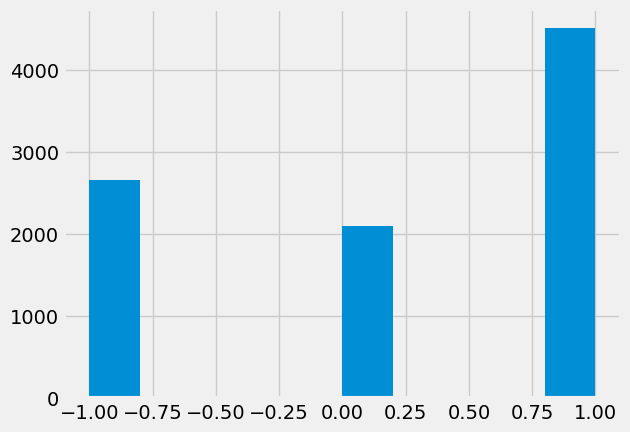

In [48]:
X['home_team_result'].hist()

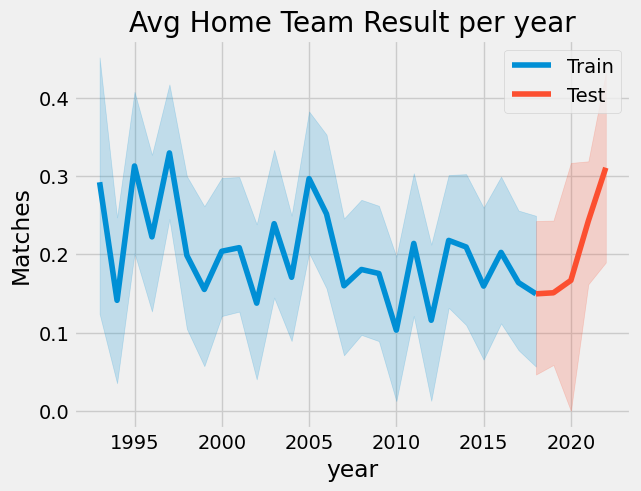

In [51]:
def plot_timeline(X, cutoff_time='2018-01-01'):
    _d = (pd.to_datetime(cutoff_time) + datetime.timedelta(days=365)).strftime('%Y-%m-%d')
    train = X[:_d]
    test = X[cutoff_time:]
    f, ax = plt.subplots()
    sns.lineplot(data=train, x='year', y='home_team_result', label='Train', ax=ax)
    sns.lineplot(data=test, x='year', y='home_team_result', label='Test', ax=ax)
    ax.set_ylabel("Matches")
    ax.set_title("Avg Home Team Result per year")
    
    return train, test
    
x1, x2 = plot_timeline(X)

Text(0.5, 1.0, 'Matches per year')

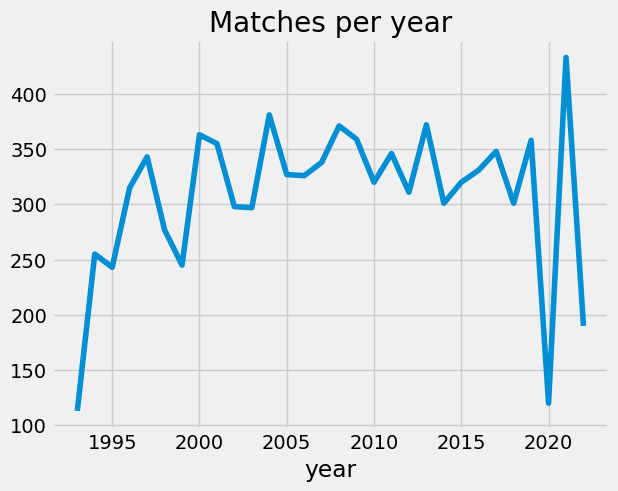

In [52]:
X.groupby('year')['home_team_result'].count().plot()
plt.title("Matches per year")

<AxesSubplot: >

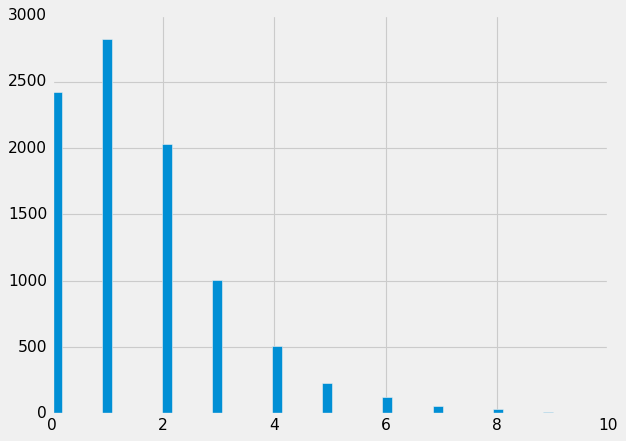

In [436]:
X[X.home_team_score < 10]['home_team_score'].hist(bins=50)

In [53]:
X.year.unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [54]:
# jogos na pandemia
X[X.year == 2020].tournament.unique()

array(['Friendly', 'UEFA Nations League', 'FIFA World Cup qualification',
       'UEFA Euro qualification'], dtype=object)

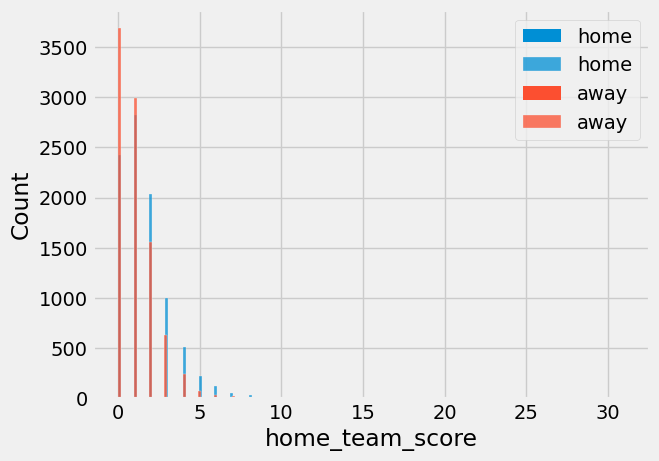

In [55]:
f, ax = plt.subplots() 

sns.histplot(data=X['home_team_score'],label='home',ax=ax)
sns.histplot(data=X['away_team_score'],label='away',ax=ax);

# ax.legend(['home', 'away'])
ax.legend()

In [56]:
X['home_team_score'].mean(), X['away_team_score'].mean()

(1.604299449065572, 1.0693529221129956)

## Split Data



In [57]:
def split_dataset(
    df,
    cutoff_time='2018-05-14',
    min_date=None,
    features_cols=features_cols,
    target=target_col,
):
    
    df = df.copy()
    if min_date:
        df = df[min_date:]
    
    t0 = (pd.to_datetime(cutoff_time) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    df_train = df[:t0]
    df_test = df[cutoff_time:]
    
    X_train, y_train = df_train[features_cols], df_train[target].to_numpy().ravel()
    X_test, y_test = df_test[features_cols], df_test[target].to_numpy().ravel()
    
    assert set(X_train.index).isdisjoint(X_test.index)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_dataset(X, min_date='2005-01-01')

In [58]:
X_train.shape

(4433, 16)

In [59]:
X_test.shape

(1339, 16)

In [60]:
X_test.shape[0] / X.shape[0]

0.14464729393972128

In [61]:
X_train.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,tournament,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
date,,,,,,,,,,,,,,,,
2005-01-12,Costa Rica,Haiti,27,95,0,0,Friendly,False,72.0,NaN,69.5,72.7,70.5,NaN,NaN,NaN
2005-01-15,Colombia,South Korea,26,22,0,0,Friendly,True,80.0,76.0,80.8,78.7,70.2,75.8,76.7,72.8
2005-01-19,Paraguay,South Korea,29,21,0,0,Friendly,True,75.0,76.0,74.5,75.0,68.2,75.8,76.7,72.8
2005-01-22,Sweden,South Korea,13,21,0,0,Friendly,True,77.0,76.0,79.5,83.3,80.8,75.8,76.7,72.8
2005-01-25,Saudi Arabia,Tajikistan,30,135,0,0,Friendly,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LGBM

In [62]:
cat_features = ['home_team', 'away_team', 'tournament', 'neutral_location']

def make_categories(df, cat_features=cat_features):
    for c in cat_features:
        df[c] = df[c].astype('category')
    return df

X_train_lgbm = make_categories(X_train)
X_test_lgbm = make_categories(X_test)

In [63]:
model_lgbm = lgbm.LGBMClassifier()
model_lgbm.fit(X_train_lgbm, y_train, categorical_feature=cat_features)

/home/luanfernandes/.pyenv/versions/copa22/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier()

In [64]:
y_train_pred = model_lgbm.predict(X_train_lgbm)
y_test_pred = model_lgbm.predict(X_test_lgbm)

In [65]:
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96      1298
           0       0.98      0.91      0.94      1006
           1       0.95      0.98      0.97      2129

    accuracy                           0.96      4433
   macro avg       0.96      0.95      0.96      4433
weighted avg       0.96      0.96      0.96      4433



In [66]:
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

          -1       0.59      0.61      0.60       392
           0       0.28      0.17      0.21       278
           1       0.69      0.78      0.73       669

    accuracy                           0.60      1339
   macro avg       0.52      0.52      0.51      1339
weighted avg       0.57      0.60      0.58      1339



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

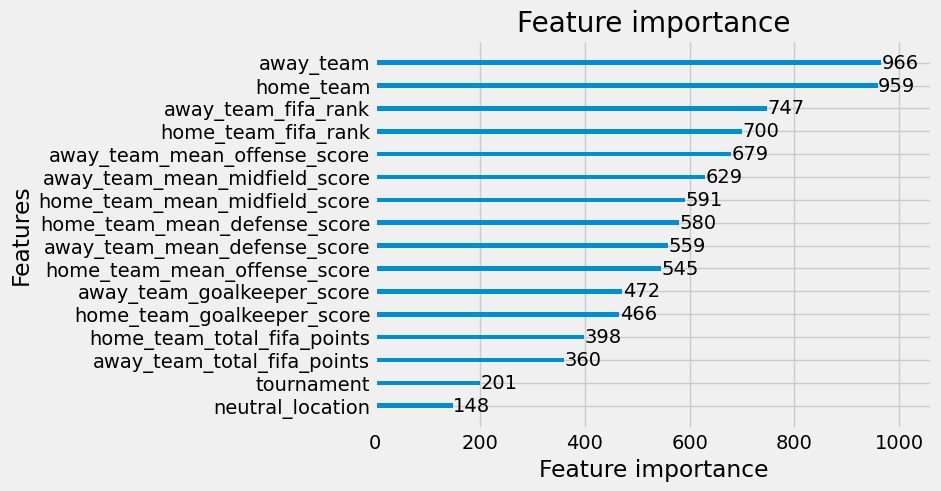

In [67]:
lgbm.plot_importance(model_lgbm)

/home/luanfernandes/.pyenv/versions/copa22/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


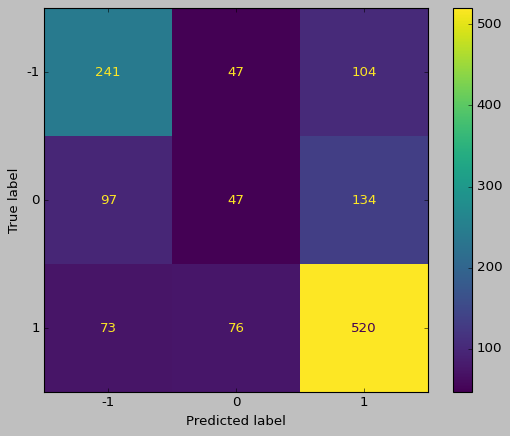

In [68]:
plt.style.use('classic')
plot_confusion_matrix(model_lgbm, X_test_lgbm, y_test)
plt.style.use("fivethirtyeight")

In [69]:
import time

ts = datetime.datetime.utcfromtimestamp(time.time()).strftime('%Y_%m_%d_%H_%M')
ts

'2022_11_20_12_32'

In [70]:
# save model

joblib.dump(model_lgbm, f'lgbm_model_{ts}.pkl')
# load model
# gbm_pickle = joblib.load('lgbm_model.pkl')

['lgbm_model_2022_11_20_12_32.pkl']

In [71]:
!ls

 lgbm_model_2022_11_20_03_36.pkl   lgbm_model_2022_11_20_12_32.pkl
 lgbm_model_2022_11_20_03_41.pkl   lgbm_model.pkl
 lgbm_model_2022_11_20_04_28.pkl  'Model GBDTs.ipynb'


## Prepare prediction dataset

Para preparar o dataset de predição, precisamos coletar as informações mais recentes de cada time para as próximas partidas reais, o que independe se estavam na coluna 'home' ou 'away'.

In [83]:
feature_metrics = [
    c for c in X.columns if re.search(r'(home|away)*?(score|points|rank)', c) 
    and not re.search(r'(home|away)_team_score', c)
]
feature_metrics

['home_team_fifa_rank',
 'away_team_fifa_rank',
 'home_team_total_fifa_points',
 'away_team_total_fifa_points',
 'home_team_goalkeeper_score',
 'away_team_goalkeeper_score',
 'home_team_mean_defense_score',
 'home_team_mean_offense_score',
 'home_team_mean_midfield_score',
 'away_team_mean_defense_score',
 'away_team_mean_offense_score',
 'away_team_mean_midfield_score']

In [96]:
def get_recent_feature_one_player(df, player, team_side):
    features = [f'{team_side}_team'] + [c for c in feature_metrics if team_side in c]
    print(features)
    _df = (
        df
        [(df[f'{team_side}_team'] == player)]
        [features]
        .fillna(method='ffill')
        .sort_index()
        .tail(1)
        .rename(columns={c: re.sub(f'{team_side}_', '', c) for c in features})
    )
    return _df

def get_recent_features(df, players2022=players2022):
    global feature_metrics
    
    df = df.copy().sort_index()
    i = 0
    for player in players2022:
        # get most recent data for player home or away
        df_home = get_recent_feature_one_player(df, player, 'home')
        df_away = get_recent_feature_one_player(df, player, 'away')
        _df = pd.concat([df_home, df_away], axis=0).sort_index().tail(1)
            
        if _df.empty:
            raise ValueError(f"i={i}: Data for team '{player}' is empty.")
        if i == 0:
            df_recent = _df
        else:
            df_recent = pd.concat([df_recent, _df], axis=0)
        i += 1

    df_recent = (
        df_recent
        .sort_index()
        .drop_duplicates(subset=['team'], keep='last')
    )
    
    return df_recent

In [85]:
df_recent = get_recent_features(X)
df_recent.head()

,team,team_fifa_rank,team_total_fifa_points,team_goalkeeper_score,team_mean_defense_score,team_mean_offense_score,team_mean_midfield_score
date,,,,,,,
2022-03-29,Qatar,52,1437,NaN,NaN,NaN,NaN
2022-06-05,Argentina,4,1765,84.0,82.2,89.0,84.0
2022-06-06,Brazil,1,1832,89.0,84.8,86.3,85.5
2022-06-07,Senegal,20,1584,83.0,79.0,80.7,79.0
2022-06-09,Cameroon,37,1480,67.0,76.8,77.7,75.0


In [86]:
df_recent[df_recent.duplicated(subset=['team'])]

,team,team_fifa_rank,team_total_fifa_points,team_goalkeeper_score,team_mean_defense_score,team_mean_offense_score,team_mean_midfield_score
date,,,,,,,


In [87]:
df_recent.isnull().sum()

team                        0
team_fifa_rank              0
team_total_fifa_points      0
team_goalkeeper_score       1
team_mean_defense_score     1
team_mean_offense_score     1
team_mean_midfield_score    1
dtype: int64

In [88]:
df_recent[df_recent.team_goalkeeper_score.isnull()]

,team,team_fifa_rank,team_total_fifa_points,team_goalkeeper_score,team_mean_defense_score,team_mean_offense_score,team_mean_midfield_score
date,,,,,,,
2022-03-29,Qatar,52,1437,NaN,NaN,NaN,NaN


In [97]:
get_recent_feature_one_player(X, 'Qatar', 'home')

['home_team', 'home_team_fifa_rank', 'home_team_total_fifa_points', 'home_team_goalkeeper_score', 'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score']


,team,team_fifa_rank,team_total_fifa_points,team_goalkeeper_score,team_mean_defense_score,team_mean_offense_score,team_mean_midfield_score
date,,,,,,,
2022-03-29,Qatar,52,1437,NaN,NaN,NaN,NaN


In [100]:
team = 'Qatar'
# X['2005':].query(f"home_team == '{team}' or away_team == '{team}'")
X['2005':].query(f"home_team == '{team}'")[[c for c in feature_metrics if 'home' in c]]

,home_team_fifa_rank,home_team_total_fifa_points,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score
date,,,,,,
2005-10-11,75,0,NaN,NaN,NaN,NaN
2005-11-16,77,0,NaN,NaN,NaN,NaN
2006-01-02,95,0,NaN,NaN,NaN,NaN
2006-02-14,89,0,NaN,NaN,NaN,NaN
2006-03-01,90,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-10,51,1431,NaN,NaN,NaN,NaN
2021-12-15,51,1431,NaN,NaN,NaN,NaN
2021-12-18,51,1431,NaN,NaN,NaN,NaN


In [101]:
set(players2022).issubset( set(df_recent.team))

True

In [102]:
df_recent.index

DatetimeIndex(['2022-03-29', '2022-06-05', '2022-06-06', '2022-06-07',
               '2022-06-09', '2022-06-09', '2022-06-11', '2022-06-11',
               '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12',
               '2022-06-12', '2022-06-13', '2022-06-13', '2022-06-13',
               '2022-06-13', '2022-06-13', '2022-06-13', '2022-06-14',
               '2022-06-14', '2022-06-14', '2022-06-14', '2022-06-14',
               '2022-06-14', '2022-06-14', '2022-06-14', '2022-06-14',
               '2022-06-14', '2022-06-14', '2022-06-14', '2022-06-14'],
              dtype='datetime64[ns]', name='date', freq=None)

In [182]:
def get_quatar_matches():
    df = (
        pd.read_csv("../../datasets/international_football_results/results.csv")
        .pipe(get_intermediate)
        .assign(date = pd.to_datetime(_df.date))
        .pipe(get_intermediate)
        .assign(year = _df.date.dt.year)
        .pipe(get_intermediate)
        [
            (_df.home_score.isnull()) # NaN values for matches are for this 48 games 2022 year
            & (_df.tournament == 'FIFA World Cup')
            & (_df.year == 2022)
        ]
        .drop(columns=['home_score', 'away_score'])
        .rename(columns={'neutral': 'neutral_location'})
        .set_index('date')
    )
    print(f"Loaded {df.shape[0]} Matches for 2022 Cup.")
    return df
    

quatar_matches = get_quatar_matches()
quatar_matches

Loaded 48 Matches for 2022 Cup.


,home_team,away_team,tournament,city,country,neutral_location,year
date,,,,,,,
2022-11-20,Qatar,Ecuador,FIFA World Cup,Al Khor,Qatar,False,2022
2022-11-21,Senegal,Netherlands,FIFA World Cup,Doha,Qatar,True,2022
2022-11-21,England,Iran,FIFA World Cup,Al Rayyan,Qatar,True,2022
2022-11-21,United States,Wales,FIFA World Cup,Al Rayyan,Qatar,True,2022
2022-11-22,Argentina,Saudi Arabia,FIFA World Cup,Lusail,Qatar,True,2022
2022-11-22,Mexico,Poland,FIFA World Cup,Doha,Qatar,True,2022
2022-11-22,Denmark,Tunisia,FIFA World Cup,Al Rayyan,Qatar,True,2022
2022-11-22,France,Australia,FIFA World Cup,Al Wakrah,Qatar,True,2022
2022-11-23,Germany,Japan,FIFA World Cup,Al Rayyan,Qatar,True,2022


In [183]:
df_recent.head()

,team,team_fifa_rank,team_total_fifa_points,team_goalkeeper_score,team_mean_defense_score,team_mean_offense_score,team_mean_midfield_score
date,,,,,,,
2022-03-29,Qatar,52,1437,NaN,NaN,NaN,NaN
2022-06-05,Argentina,4,1765,84.0,82.2,89.0,84.0
2022-06-06,Brazil,1,1832,89.0,84.8,86.3,85.5
2022-06-07,Senegal,20,1584,83.0,79.0,80.7,79.0
2022-06-09,Cameroon,37,1480,67.0,76.8,77.7,75.0


In [184]:
df_recent.columns

Index(['team', 'team_fifa_rank', 'team_total_fifa_points',
       'team_goalkeeper_score', 'team_mean_defense_score',
       'team_mean_offense_score', 'team_mean_midfield_score'],
      dtype='object')

In [185]:
def merge_features(df_prediction, df_recent, players):
    """
    For each player, we get most recent features.
    """
    df_final = df_prediction.sort_index().copy()
    df_recent = df_recent.sort_index()
    
    # merge each case
    df_final = pd.merge_asof(
        left=df_final,
        right=df_recent.rename(columns={c: f'home_{c}' for c in df_recent.columns}),
        left_index=True,
        right_index=True,
        left_by='home_team',
        right_by='home_team'
    )
    df_final = pd.merge_asof(
        left=df_final,
        right=df_recent.rename(columns={c: f'away_{c}' for c in df_recent.columns}),
        left_index=True,
        right_index=True,
        left_by='away_team',
        right_by='away_team'
    )
        
    # Assert we got all games
    assert df_prediction.shape[0] == df_final.shape[0]
        
    return df_final

In [186]:
df_prediction = merge_features(quatar_matches, df_recent, players2022)
df_prediction

,home_team,away_team,tournament,city,country,neutral_location,year,home_team_fifa_rank,home_team_total_fifa_points,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_fifa_rank,away_team_total_fifa_points,away_team_goalkeeper_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
date,,,,,,,,,,,,,,,,,,,
2022-11-20,Qatar,Ecuador,FIFA World Cup,Al Khor,Qatar,False,2022,52,1437,NaN,NaN,NaN,NaN,46,1452,71.0,73.5,76.0,74.5
2022-11-21,Senegal,Netherlands,FIFA World Cup,Doha,Qatar,True,2022,20,1584,83.0,79.0,80.7,79.0,10,1658,81.0,85.2,83.0,83.5
2022-11-21,England,Iran,FIFA World Cup,Al Rayyan,Qatar,True,2022,5,1761,83.0,85.0,88.0,84.0,21,1564,73.0,69.0,75.3,69.0
2022-11-21,United States,Wales,FIFA World Cup,Al Rayyan,Qatar,True,2022,15,1633,77.0,75.8,77.7,75.8,18,1588,74.0,75.0,73.0,78.5
2022-11-22,Argentina,Saudi Arabia,FIFA World Cup,Lusail,Qatar,True,2022,4,1765,84.0,82.2,89.0,84.0,49,1444,70.0,72.8,67.7,72.8
2022-11-22,Mexico,Poland,FIFA World Cup,Doha,Qatar,True,2022,9,1658,80.0,76.8,82.7,78.2,26,1544,87.0,75.2,84.7,75.8
2022-11-22,Denmark,Tunisia,FIFA World Cup,Al Rayyan,Qatar,True,2022,11,1653,85.0,80.2,77.7,80.2,35,1499,58.0,70.8,72.3,74.0
2022-11-22,France,Australia,FIFA World Cup,Al Wakrah,Qatar,True,2022,3,1789,87.0,84.2,88.3,86.8,42,1462,77.0,72.0,72.3,73.5
2022-11-23,Germany,Japan,FIFA World Cup,Al Rayyan,Qatar,True,2022,12,1650,90.0,84.0,82.7,87.8,23,1553,73.0,75.2,75.0,77.5


In [187]:
df_prediction.to_csv('../../datasets/predictions/quatar2022_features.csv')

## Simular a Copa 2022

Agora, vamos simular os resultados da copa 2022 usando o modelo. Para isso, vamos criar uma classe que receberá como entrada o dataframe com as features mais recentes dos times da copa, um modelo treinado, e a informação das chaves dos grupos. 

Antes de prever os gols dos times com técnicas mais complexas, vamos assumir que, quando for previsto empate, vence quem tem mais rating da FIFA. Depois, vamos montar simulações usando a previsão dos gols com distribuição de Poisson.

In [ ]:

# min_date='2005-01-01'

In [249]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4433 entries, 2005-01-12 to 2018-05-09
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   home_team                      4433 non-null   category
 1   away_team                      4433 non-null   category
 2   home_team_fifa_rank            4433 non-null   int64   
 3   away_team_fifa_rank            4433 non-null   int64   
 4   home_team_total_fifa_points    4433 non-null   int64   
 5   away_team_total_fifa_points    4433 non-null   int64   
 6   tournament                     4433 non-null   category
 7   neutral_location               4433 non-null   category
 8   home_team_goalkeeper_score     3407 non-null   float64 
 9   away_team_goalkeeper_score     3322 non-null   float64 
 10  home_team_mean_defense_score   3346 non-null   float64 
 11  home_team_mean_offense_score   3518 non-null   float64 
 12  home_team_mean_m

In [252]:
np.concatenate((y_train, y_test))

array([ 0,  1,  0, ..., -1, -1,  1])

In [253]:
X_train_full = make_categories( pd.concat([X_train_lgbm, X_test_lgbm]))
y_train_full = np.concatenate((y_train, y_test))

prediction_model = lgbm.LGBMClassifier()
prediction_model.fit(
    X_train_full, 
    y_train_full, 
    categorical_feature=cat_features
)

/home/luanfernandes/.pyenv/versions/copa22/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier()

In [383]:
# save prediction model
ts = datetime.datetime.utcfromtimestamp(time.time()).strftime('%Y_%m_%d_%H_%M')
joblib.dump(prediction_model, f'predictions/lgbm_model_prediction_{ts}.pkl')

['predictions/lgbm_model_prediction_2022_11_20_15_25.pkl']

In [261]:
class GroupMatchesSimulator():
    """
    Classe para simular as partidas da Copa de 2022.
    """
    def __init__(self, df, model, features, target_name='home_team_result'):
        self.df = df
        self.model = model
        self.features = features
        self.target_name = target_name
        
    def run_simulation(self):
        _X_pred = make_categories(self.df[self.features]) # lgbm needs 'objects' string to be 'category'
        y_pred = self.model.predict(_X_pred)
        self.df[self.target_name] = y_pred

In [262]:
simulator = GroupMatchesSimulator(df_prediction, prediction_model, features=X_train_full.columns)

In [263]:
simulator.run_simulation()

In [264]:
simulator.df

,home_team,away_team,tournament,city,country,neutral_location,year,home_team_fifa_rank,home_team_total_fifa_points,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_fifa_rank,away_team_total_fifa_points,away_team_goalkeeper_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_team_result
date,,,,,,,,,,,,,,,,,,,,
2022-11-20,Qatar,Ecuador,FIFA World Cup,Al Khor,Qatar,False,2022,52,1437,NaN,NaN,NaN,NaN,46,1452,71.0,73.5,76.0,74.5,1
2022-11-21,Senegal,Netherlands,FIFA World Cup,Doha,Qatar,True,2022,20,1584,83.0,79.0,80.7,79.0,10,1658,81.0,85.2,83.0,83.5,-1
2022-11-21,England,Iran,FIFA World Cup,Al Rayyan,Qatar,True,2022,5,1761,83.0,85.0,88.0,84.0,21,1564,73.0,69.0,75.3,69.0,1
2022-11-21,United States,Wales,FIFA World Cup,Al Rayyan,Qatar,True,2022,15,1633,77.0,75.8,77.7,75.8,18,1588,74.0,75.0,73.0,78.5,1
2022-11-22,Argentina,Saudi Arabia,FIFA World Cup,Lusail,Qatar,True,2022,4,1765,84.0,82.2,89.0,84.0,49,1444,70.0,72.8,67.7,72.8,1
2022-11-22,Mexico,Poland,FIFA World Cup,Doha,Qatar,True,2022,9,1658,80.0,76.8,82.7,78.2,26,1544,87.0,75.2,84.7,75.8,-1
2022-11-22,Denmark,Tunisia,FIFA World Cup,Al Rayyan,Qatar,True,2022,11,1653,85.0,80.2,77.7,80.2,35,1499,58.0,70.8,72.3,74.0,1
2022-11-22,France,Australia,FIFA World Cup,Al Wakrah,Qatar,True,2022,3,1789,87.0,84.2,88.3,86.8,42,1462,77.0,72.0,72.3,73.5,1
2022-11-23,Germany,Japan,FIFA World Cup,Al Rayyan,Qatar,True,2022,12,1650,90.0,84.0,82.7,87.8,23,1553,73.0,75.2,75.0,77.5,1


## Simular o número de gols na Copa 2022

In [270]:
from empiricaldist import Pmf
from scipy.stats import poisson

def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

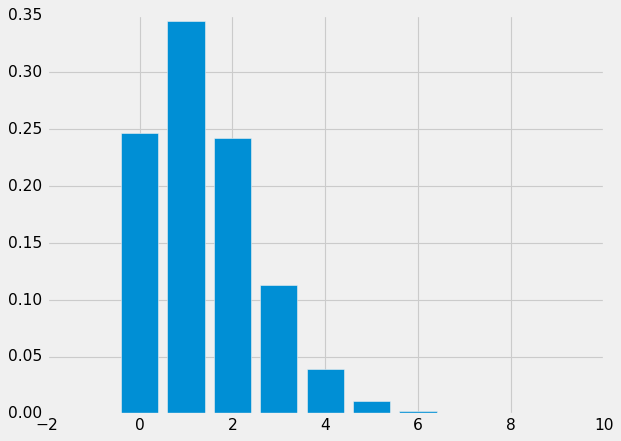

In [273]:
import numpy as np

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

In [277]:
X['home_team_score'].head().to_list()

[3, 1, 5, 1, 1]

In [295]:
def estimate_goals(X, teams):
    """
    Gera uma distribuição de Poisson para cada time.
    """
    dists = {}
    for team in teams:
        goals_home = X[(X.home_team == team)]['home_team_score'].to_list()
        goals_away = X[(X.away_team == team)]['away_team_score'].to_list()
        goals = np.array(goals_home + goals_away)
        lam = goals.mean()
        print(f"Team {team} lambda={lam}")
        
        goals_range = np.arange(10)
        pmf_goals = make_poisson_pmf(lam, goals_range)
        dists[team] = (lam, pmf_goals)
    
    return dists

def plot_poisson_dist(dists, team):
    lam, pmf_goals = dists[team]
    pmf_goals.bar()
    plt.title(f"Poisson distribution for team '{team}' and $\lambda={round(lam,2)}$")
    
def predict_goals(dists, team):
    lam, pmf_goals = dists[team]
    return np.argmax(pmf_goals)

In [292]:
possion_dists = estimate_goals(X['2005-01-01':], players2022)

Team Argentina lambda=1.8447488584474885
Team Australia lambda=1.745
Team Belgium lambda=2.0885416666666665
Team Brazil lambda=2.2155172413793105
Team Cameroon lambda=1.3248730964467006
Team Canada lambda=1.4820143884892085
Team Costa Rica lambda=1.248062015503876
Team Croatia lambda=1.7536945812807883
Team Denmark lambda=1.6789473684210525
Team Ecuador lambda=1.3869346733668342
Team England lambda=2.023696682464455
Team France lambda=1.7565217391304349
Team Germany lambda=2.3771186440677967
Team Ghana lambda=1.439252336448598
Team Iran lambda=1.7918552036199096
Team Japan lambda=1.856060606060606
Team Mexico lambda=1.6449511400651466
Team Morocco lambda=1.5958549222797926
Team Netherlands lambda=2.0610328638497655
Team Poland lambda=1.6635514018691588
Team Portugal lambda=1.918552036199095
Team Qatar lambda=1.471042471042471
Team Saudi Arabia lambda=1.496031746031746
Team Senegal lambda=1.5056179775280898
Team Serbia lambda=1.5056818181818181
Team South Korea lambda=1.5098814229249011

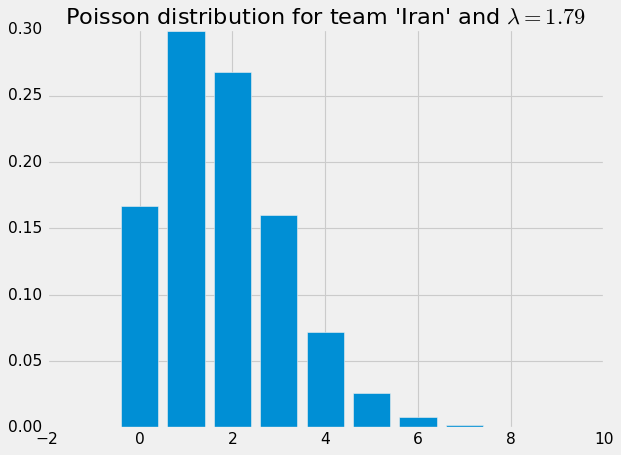

In [545]:
plot_poisson_dist(possion_dists, 'Iran')

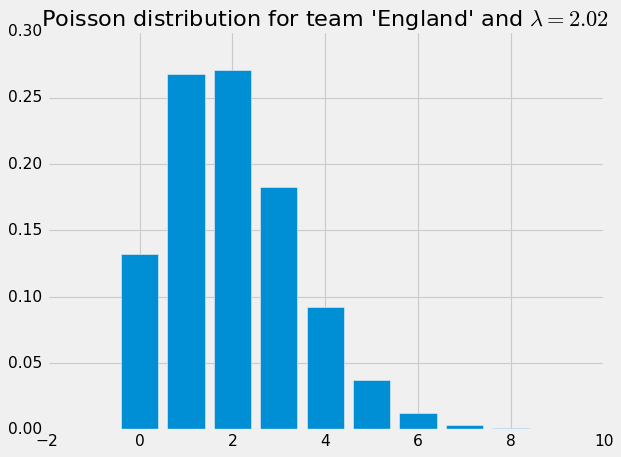

In [420]:
plot_poisson_dist(possion_dists, 'England')

In [298]:
# likely goals 
print(predict_goals(possion_dists, 'Brazil'))
print(predict_goals(possion_dists, 'England'))
print(predict_goals(possion_dists, 'Senegal'))

2
2
1


### Adicionar número de gols nas previsões

In [301]:
def print_placar_final():
    pass

In [300]:
df_prediction[['home_team', 'away_team', 'home_team_result']]

,home_team,away_team,home_team_result
date,,,
2022-11-20,Qatar,Ecuador,1
2022-11-21,Senegal,Netherlands,-1
2022-11-21,England,Iran,1
2022-11-21,United States,Wales,1
2022-11-22,Argentina,Saudi Arabia,1
2022-11-22,Mexico,Poland,-1
2022-11-22,Denmark,Tunisia,1
2022-11-22,France,Australia,1
2022-11-23,Germany,Japan,1


In [309]:
def add_goals_to_predictions(df, poisson_dists):
    df_goals = df_prediction[['home_team', 'away_team', 'home_team_result']]
    
    df_goals['home_score'] = df_goals['home_team'].apply(lambda x: predict_goals(possion_dists, x))
    df_goals['away_score'] = df_goals['away_team'].apply(lambda x: predict_goals(possion_dists, x))
    df_goals['home_results_by_goals'] = np.sign((df_goals['home_score'] - df_goals['away_score']))
    df_goals['are_both_preds_equal'] = df_goals['home_results_by_goals'] == df_goals['home_team_result']
    
    return df_goals

{'Germany': 'GER',
 'Netherlands': 'NED',
 'Brazil': 'BRA',
 'Italy': 'ITA',
 'Spain': 'ESP',
 'Norway': 'NOR',
 'Romania': 'ROU',
 'Argentina': 'ARG',
 'Denmark': 'DEN',
 'Sweden': 'SWE',
 'Nigeria': 'NGA',
 'Switzerland': 'SUI',
 'France': 'FRA',
 'Republic of Ireland': 'IRL',
 'England': 'ENG',
 'Mexico': 'MEX',
 'Colombia': 'COL',
 'Uruguay': 'URU',
 'Russia': 'RUS',
 'Zambia': 'ZAM',
 "Côte d'Ivoire": 'CIV',
 'Portugal': 'POR',
 'United States': 'USA',
 'Cameroon': 'CMR',
 'Egypt': 'EGY',
 'Ghana': 'GHA',
 'Belgium': 'BEL',
 'Morocco': 'MAR',
 'Bulgaria': 'BUL',
 'Tunisia': 'TUN',
 'Greece': 'GRE',
 'Poland': 'POL',
 'Scotland': 'SCO',
 'Saudi Arabia': 'KSA',
 'Wales': 'WAL',
 'Austria': 'AUT',
 'South Korea': 'KOR',
 'Iceland': 'ISL',
 'Ecuador': 'ECU',
 'Chile': 'CHI',
 'Northern Ireland': 'NIR',
 'Zimbabwe': 'ZIM',
 'Bolivia': 'BOL',
 'Slovakia': 'SVK',
 'Czech Republic': 'CZE',
 'Finland': 'FIN',
 'Australia': 'AUS',
 'Algeria': 'ALG',
 'Mali': 'MLI',
 'Honduras': 'HON',
 'Cos

In [333]:
df_prediction_with_goals = add_goals_to_predictions(df_prediction, possion_dists)

df_prediction_with_goals

,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal
date,,,,,,,
2022-11-20,Qatar,Ecuador,1,1,1,0,False
2022-11-21,Senegal,Netherlands,-1,1,2,-1,True
2022-11-21,England,Iran,1,2,1,1,True
2022-11-21,United States,Wales,1,1,1,0,False
2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False
2022-11-22,Mexico,Poland,-1,1,1,0,False
2022-11-22,Denmark,Tunisia,1,1,1,0,False
2022-11-22,France,Australia,1,1,1,0,False
2022-11-23,Germany,Japan,1,2,1,1,True


In [351]:
df_prediction_with_goals[~df_prediction_with_goals.are_both_preds_equal]

,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,home_code,away_code
date,,,,,,,,,
2022-11-20,Qatar,Ecuador,1,1,1,0,False,QAT,ECU
2022-11-21,United States,Wales,1,1,1,0,False,USA,WAL
2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False,ARG,KSA
2022-11-22,Mexico,Poland,-1,1,1,0,False,MEX,POL
2022-11-22,Denmark,Tunisia,1,1,1,0,False,DEN,TUN
2022-11-22,France,Australia,1,1,1,0,False,FRA,AUS
2022-11-23,Morocco,Croatia,-1,1,1,0,False,MAR,CRO
2022-11-24,Switzerland,Cameroon,1,1,1,0,False,SUI,CMR
2022-11-24,Uruguay,South Korea,1,1,1,0,False,URU,KOR


## Preparar submissão

In [311]:
!head -n 10 ../../../sigmageek/submission.csv

In [241]:
!head -n 10 ../../../sigmageek/results.csv

QAT 3,ECU 2
SEN 2,NED 0
ENG 1,IRN 3
USA 3,WAL 3
FRA 3,AUS 3
DEN 0,TUN 0
MEX 0,POL 2
ARG 3,KSA 2
BEL 2,CAN 2
ESP 2,CRC 2


In [312]:
with open('../../../sigmageek/results.csv', 'r') as f:
    lines = f.readlines()

games_order = []
for line in lines:
    team1 = re.findall('[\w]+', line)[0]
    team2 = re.findall('[\w]+', line)[2]
    games_order.append((team1, team2))
    
games_order[:10]

[('QAT', 'ECU'),
 ('SEN', 'NED'),
 ('ENG', 'IRN'),
 ('USA', 'WAL'),
 ('FRA', 'AUS'),
 ('DEN', 'TUN'),
 ('MEX', 'POL'),
 ('ARG', 'KSA'),
 ('BEL', 'CAN'),
 ('ESP', 'CRC')]

In [350]:
games_order

[('QAT', 'ECU'),
 ('SEN', 'NED'),
 ('ENG', 'IRN'),
 ('USA', 'WAL'),
 ('FRA', 'AUS'),
 ('DEN', 'TUN'),
 ('MEX', 'POL'),
 ('ARG', 'KSA'),
 ('BEL', 'CAN'),
 ('ESP', 'CRC'),
 ('GER', 'JPN'),
 ('MAR', 'CRO'),
 ('SUI', 'CMR'),
 ('URU', 'KOR'),
 ('POR', 'GHA'),
 ('BRA', 'SRB'),
 ('WAL', 'IRN'),
 ('QAT', 'SEN'),
 ('NED', 'ECU'),
 ('ENG', 'USA'),
 ('TUN', 'AUS'),
 ('POL', 'KSA'),
 ('FRA', 'DEN'),
 ('ARG', 'MEX'),
 ('JPN', 'CRC'),
 ('BEL', 'MAR'),
 ('CRO', 'CAN'),
 ('ESP', 'GER'),
 ('CMR', 'SRB'),
 ('KOR', 'GHA'),
 ('BRA', 'SUI'),
 ('POR', 'URU'),
 ('WAL', 'ENG'),
 ('IRN', 'USA'),
 ('ECU', 'SEN'),
 ('NED', 'QAT'),
 ('AUS', 'DEN'),
 ('TUN', 'FRA'),
 ('POL', 'ARG'),
 ('KSA', 'MEX'),
 ('CRO', 'BEL'),
 ('CAN', 'MAR'),
 ('JPN', 'ESP'),
 ('CRC', 'GER'),
 ('GHA', 'URU'),
 ('KOR', 'POR'),
 ('SRB', 'SUI'),
 ('CMR', 'BRA')]

In [457]:
def merge_names2(df):
    mapper = {
        'IR Iran': 'Iran',
        'USA': 'United States',
        'Korea Republic': 'South Korea'
    }
    df['Team'] = df['Team'].apply(lambda x: mapper.get(x, x))
    return df

mapper_siglas = (
    pd.read_csv('../../datasets/fifa_ranking_before_wc_preprocessed.csv')
    .pipe(merge_names2)
    [['code', 'Team']]
    .set_index('Team')
    .to_dict()
    ['code']
)

def make_final_score(row, treat_special_case=True):
    # tratar caso especial de chave (QAT, NED), 2022-11-29, que deveria ser (NED, QAT)
    if treat_special_case and row.home_code == 'QAT' and row.away_code == 'NED':
        print("Treating special case.")
        v = row.home_score
        row.home_score = row.away_score
        row.away_score = v
        # row.are_both_preds_equal does not change
        # home_team_result inverse
        row.home_team_result = - row.home_team_result
        row.home_results_by_goals = - row.home_results_by_goals
        
    # if 'are_both_preds_equal' is True, we just return the gols predicted
    if row.are_both_preds_equal:
        h = int(row.home_score)
        a = int(row.away_score)
        return str(h) + 'x' + str(a)
    else:
        # in this case, we keep the LGBM prediction and have two cases:
        # lgbm model said draw, goals not. We can keep the smallest goal predicted
        # lgbm model said some winner, goals said draw or inverse result. Here, we increase
        # one by one goal from model's winner to achieve the model's prediction
        
        # lgbm says draw
        if row.home_team_result == 0:
            smallest = int(min(row.home_score, row.away_score))
            return str(smallest) + 'x' + str(smallest)
        # lgbm said some winner
        else:
            # goals said draw
            if row.home_results_by_goals == 0:
                # give one more goal to lgbm's winner or remove 1 from loser if possible
                # and random
                if np.random.random() <= 0.5:
                    # winner takes
                    if row.home_team_result == 1:
                        h = int(row.home_score + 1)
                        a = int(row.away_score)
                    else:
                        h = int(row.home_score)
                        a = int(row.away_score + 1)
                    return str(h) + 'x' + str(a)
                else:
                    # loser gets one less goal
                    if row.home_team_result == 1:
                        h = int(row.home_score)
                        a = int(row.away_score - 1)
                    else:
                        h = int(row.home_score - 1)
                        a = int(row.away_score)
                    return str(h) + 'x' + str(a)
                    
            else:
                # goals said some winner different from lgbm
                raise ValueError("Caso não tratato.")
            

def prepare_submission(df, treat_special_case=True):

    df_submission = df.copy()

    df_submission['home_code'] = df_submission.home_team.apply(lambda x: mapper_siglas[x])
    df_submission['away_code'] = df_submission.away_team.apply(lambda x: mapper_siglas[x])
    df_submission['key'] = df_submission.apply(
        lambda row: 
        (row.home_code, row.away_code) 
        if (row.home_code, row.away_code) != ('QAT', 'NED')
        else ('NED', 'QAT')
        , axis=1)
    df_submission = (
        df_submission
        .reset_index()
        .set_index('key')
        .reindex(games_order)
    )
    
    df_submission['final_score'] = df_submission.apply(lambda x: make_final_score(x, treat_special_case), axis=1)
    
    return df_submission

In [458]:
df_submission = prepare_submission(df_prediction_with_goals)

df_submission

Treating special case.


,date,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,home_code,away_code,final_score
key,,,,,,,,,,,
"(QAT, ECU)",2022-11-20,Qatar,Ecuador,1,1,1,0,False,QAT,ECU,2x1
"(SEN, NED)",2022-11-21,Senegal,Netherlands,-1,1,2,-1,True,SEN,NED,1x2
"(ENG, IRN)",2022-11-21,England,Iran,1,2,1,1,True,ENG,IRN,2x1
"(USA, WAL)",2022-11-21,United States,Wales,1,1,1,0,False,USA,WAL,1x0
"(FRA, AUS)",2022-11-22,France,Australia,1,1,1,0,False,FRA,AUS,2x1
"(DEN, TUN)",2022-11-22,Denmark,Tunisia,1,1,1,0,False,DEN,TUN,2x1
"(MEX, POL)",2022-11-22,Mexico,Poland,-1,1,1,0,False,MEX,POL,0x1
"(ARG, KSA)",2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False,ARG,KSA,2x1
"(BEL, CAN)",2022-11-23,Belgium,Canada,1,2,1,1,True,BEL,CAN,2x1


In [459]:
df_submission.drop(columns=['home_code', 'away_code'])

,date,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,final_score
key,,,,,,,,,
"(QAT, ECU)",2022-11-20,Qatar,Ecuador,1,1,1,0,False,2x1
"(SEN, NED)",2022-11-21,Senegal,Netherlands,-1,1,2,-1,True,1x2
"(ENG, IRN)",2022-11-21,England,Iran,1,2,1,1,True,2x1
"(USA, WAL)",2022-11-21,United States,Wales,1,1,1,0,False,1x0
"(FRA, AUS)",2022-11-22,France,Australia,1,1,1,0,False,2x1
"(DEN, TUN)",2022-11-22,Denmark,Tunisia,1,1,1,0,False,2x1
"(MEX, POL)",2022-11-22,Mexico,Poland,-1,1,1,0,False,0x1
"(ARG, KSA)",2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False,2x1
"(BEL, CAN)",2022-11-23,Belgium,Canada,1,2,1,1,True,2x1


In [461]:
df_submission[['final_score']].to_csv(f"predictions/submission.csv", index=False, header=False)

In [462]:
df_submission.shape

(48, 11)

In [463]:
!pwd

/home/luanfernandes/projects/personal/copa/copa22-forecast/code/model


In [464]:
!ls predictions

lgbm_model_prediction_2022_11_20_15_25.pkl  submission_2022_11_20_15_37.csv
lgbm_model_prediction_2022_11_20_15_25.zip  submission.csv
submission_2022_11_20_15_25.csv		    submission_full_columns.csv


In [465]:
!head -n 20 predictions/submission.csv

2x1
1x2
2x1
1x0
2x1
2x1
0x1
2x1
2x1
2x1
2x1
1x2
2x1
2x1
1x0
2x1
0x1
1x2
2x1
2x1


### Final Results Group Matches

Vamos gerar os mesmos resultados, mas sem tratar um caso especial que só foi feito para a competição da sigmageek.

In [476]:
df_groupmatches_results = prepare_submission(df_prediction_with_goals, treat_special_case=False)

df_groupmatches_results['home_final_score'] = df_groupmatches_results['final_score'].apply(lambda x: x.split('x')[0])
df_groupmatches_results['away_final_score'] = df_groupmatches_results['final_score'].apply(lambda x: x.split('x')[1])

df_groupmatches_results

,date,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,home_code,away_code,final_score,home_final_score,away_final_score
key,,,,,,,,,,,,,
"(QAT, ECU)",2022-11-20,Qatar,Ecuador,1,1,1,0,False,QAT,ECU,1x0,1,0
"(SEN, NED)",2022-11-21,Senegal,Netherlands,-1,1,2,-1,True,SEN,NED,1x2,1,2
"(ENG, IRN)",2022-11-21,England,Iran,1,2,1,1,True,ENG,IRN,2x1,2,1
"(USA, WAL)",2022-11-21,United States,Wales,1,1,1,0,False,USA,WAL,1x0,1,0
"(FRA, AUS)",2022-11-22,France,Australia,1,1,1,0,False,FRA,AUS,2x1,2,1
"(DEN, TUN)",2022-11-22,Denmark,Tunisia,1,1,1,0,False,DEN,TUN,2x1,2,1
"(MEX, POL)",2022-11-22,Mexico,Poland,-1,1,1,0,False,MEX,POL,1x2,1,2
"(ARG, KSA)",2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False,ARG,KSA,2x1,2,1
"(BEL, CAN)",2022-11-23,Belgium,Canada,1,2,1,1,True,BEL,CAN,2x1,2,1


In [546]:
df_groupmatches_results[['date', 'home_team', 'away_team', 'home_team_result', 'home_score','away_score', 'home_results_by_goals', 'are_both_preds_equal', 'final_score']]

,date,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,final_score
key,,,,,,,,,
"(QAT, ECU)",2022-11-20,Qatar,Ecuador,1,1,1,0,False,1x0
"(SEN, NED)",2022-11-21,Senegal,Netherlands,-1,1,2,-1,True,1x2
"(ENG, IRN)",2022-11-21,England,Iran,1,2,1,1,True,2x1
"(USA, WAL)",2022-11-21,United States,Wales,1,1,1,0,False,1x0
"(FRA, AUS)",2022-11-22,France,Australia,1,1,1,0,False,2x1
"(DEN, TUN)",2022-11-22,Denmark,Tunisia,1,1,1,0,False,2x1
"(MEX, POL)",2022-11-22,Mexico,Poland,-1,1,1,0,False,1x2
"(ARG, KSA)",2022-11-22,Argentina,Saudi Arabia,1,1,1,0,False,2x1
"(BEL, CAN)",2022-11-23,Belgium,Canada,1,2,1,1,True,2x1


In [477]:
df_groupmatches_results.to_csv(f"predictions/submission_full_columns.csv")

In [508]:
def get_groups(df):
    keys = list(df.index)
    groups = {
        'A': ['QAT'],
        'B': ['ENG'],
        'C': ['ARG'],
        'D': ['FRA'],
        'E': ['ESP'],
        'F': ['BEL'],
        'G': ['BRA'],
        'H': ['POR']
    }
    team2group = {v[0]: k for k,v in groups.items()}
    for group, teams in groups.items():
        team1 = teams[0]
        for key in keys:
            if key[0] == team1:
                v = key[1]
            elif key[1] == team1:
                v = key[0]
            else:
                continue
            if v not in groups[group]:
                groups[group].append(v)
                team2group[v] = group
        
    return groups, team2group

            
group2teams, teams2groups = get_groups(df_groupmatches_results)
group2teams, teams2groups

({'A': ['QAT', 'ECU', 'SEN', 'NED'],
  'B': ['ENG', 'IRN', 'USA', 'WAL'],
  'C': ['ARG', 'KSA', 'MEX', 'POL'],
  'D': ['FRA', 'AUS', 'DEN', 'TUN'],
  'E': ['ESP', 'CRC', 'GER', 'JPN'],
  'F': ['BEL', 'CAN', 'MAR', 'CRO'],
  'G': ['BRA', 'SRB', 'SUI', 'CMR'],
  'H': ['POR', 'GHA', 'URU', 'KOR']},
 {'QAT': 'A',
  'ENG': 'B',
  'ARG': 'C',
  'FRA': 'D',
  'ESP': 'E',
  'BEL': 'F',
  'BRA': 'G',
  'POR': 'H',
  'ECU': 'A',
  'SEN': 'A',
  'NED': 'A',
  'IRN': 'B',
  'USA': 'B',
  'WAL': 'B',
  'KSA': 'C',
  'MEX': 'C',
  'POL': 'C',
  'AUS': 'D',
  'DEN': 'D',
  'TUN': 'D',
  'CRC': 'E',
  'GER': 'E',
  'JPN': 'E',
  'CAN': 'F',
  'MAR': 'F',
  'CRO': 'F',
  'SRB': 'G',
  'SUI': 'G',
  'CMR': 'G',
  'GHA': 'H',
  'URU': 'H',
  'KOR': 'H'})

In [530]:
def final_groupmatches_results(results, players2022, teams2groups, filter_winners=False):
    
    players_results = pd.DataFrame(data={'team': [], 'points': [], 'group': []})
    for player in players2022:
        acr = results[results.home_team == player].head(1)['home_code'].values[0] 
        points_home = (
            (results[results.home_team == player].home_team_result > 0) * 3 
            + (results[results.home_team == player].home_team_result == 0) * 1
        ).sum()
        points_away = (
            (results[results.away_team == player].home_team_result < 0) * 3 
            + (results[results.away_team == player].home_team_result == 0) * 1
        ).sum()
        points = points_home + points_away
        df = pd.DataFrame(data={'team': [player], 'points': [points], 'group': teams2groups[acr]})
        players_results = (
            pd.concat([players_results, df], axis=0)
            .sort_values(by=['group', 'points'], ascending=[True, False])
        )
    players_results['ranking'] = players_results.groupby("group")['points'].rank(ascending=False).astype('int')
    if filter_winners:
        players_results = players_results[players_results.ranking <= 2]
    return players_results

In [534]:
df_final_groupmatches_results = final_groupmatches_results(df_groupmatches_results, players2022, teams2groups)
df_final_groupmatches_results

,team,points,group,ranking
0,Netherlands,9.0,A,1
0,Senegal,6.0,A,2
0,Qatar,3.0,A,3
0,Ecuador,0.0,A,4
0,England,9.0,B,1
0,Iran,4.0,B,2
0,United States,4.0,B,2
0,Wales,0.0,B,4
0,Argentina,9.0,C,1
0,Poland,6.0,C,2


In [532]:
final_groupmatches_results(df_groupmatches_results, players2022, teams2groups, filter_winners=True)

,team,points,group,ranking
0,Netherlands,9.0,A,1
0,Senegal,6.0,A,2
0,England,9.0,B,1
0,Iran,4.0,B,2
0,United States,4.0,B,2
0,Argentina,9.0,C,1
0,Poland,6.0,C,2
0,Denmark,9.0,D,1
0,France,4.0,D,2
0,Germany,9.0,E,1


In [536]:
df_final_groupmatches_results.to_csv("predictions/final_groupmatches_results.csv")

In [543]:
!ls predictions/

final_groupmatches_results.csv		    submission.csv
lgbm_model_prediction_2022_11_20_15_25.pkl  submission_full_columns.csv
lgbm_model_prediction_2022_11_20_15_25.zip


In [521]:
def see_team_results(df_groupmatches_results, team):
    df = df_groupmatches_results
    return df[(df.home_team == team) | (df.away_team == team)]

see_team_results(df_groupmatches_results, 'Brazil')

,date,home_team,away_team,home_team_result,home_score,away_score,home_results_by_goals,are_both_preds_equal,home_code,away_code,final_score,home_final_score,away_final_score
key,,,,,,,,,,,,,
"(BRA, SRB)",2022-11-24,Brazil,Serbia,1,2,1,1,True,BRA,SRB,2x1,2,1
"(BRA, SUI)",2022-11-28,Brazil,Switzerland,1,2,1,1,True,BRA,SUI,2x1,2,1
"(CMR, BRA)",2022-12-02,Cameroon,Brazil,-1,1,2,-1,True,CMR,BRA,1x2,1,2
